# Event Analysis
This notebook adds labels to events, creates time series of the events, ancreates location distribution figures of the events from the PNSN, and creates 10/10/22 fskene@uw.edu

In [2]:
# import modules
import matplotlib.pyplot as plt
from matplotlib.pyplot import Figure
import numpy as np
import pandas as pd
import obspy
from obspy.core import UTCDateTime
from obspy.clients.fdsn.client import Client
from obspy.geodetics import *
from obspy.core.utcdatetime import UTCDateTime
import requests
from mpl_toolkits.axes_grid1 import make_axes_locatable
from geopy import distance
import datetime
import rasterio as rio
from rasterio.plot import show
from rasterio.merge import merge
import richdem as rd
from pathlib import Path
import os 
import glob
from scipy.stats import norm
import sys
import seaborn as sns
from scipy import stats
from scipy.optimize import curve_fit
from scipy import asarray as ar,exp
from pyproj import Proj,transform,Geod
from matplotlib.lines import Line2D
from scipy.interpolate import RectBivariateSpline
import warnings
import json

In [3]:
# establish parameters
window = 30 #window length of the signal
thr = 12 #SNR threshold
station_distance_threshold = 25
pi = np.pi
v_s = 1000 #shear wave velocity at the surface
colors = list(plt.cm.tab10(np.arange(10)))*3
radius = 6371e3
ratio = 5.6915196

warnings.filterwarnings("ignore")

In [4]:
# define functions
def volc_loc_thr(left_lat, bottom_lon, sidelength):
    d = distance.geodesic(meters = sidelength)
    right_lat = d.destination(point=[left_lat,bottom_lon], bearing=0)[0]
    top_lon = d.destination(point=[left_lat,bottom_lon], bearing=90)[1]
    return right_lat, top_lon

def start_latlon(elevation, ratio, center_lat, center_lon):
    side_length = elevation * ratio
    l = side_length/2
    hypotenuse = l*np.sqrt(2)
    d = distance.geodesic(meters = hypotenuse)
    start_lat = d.destination(point=[center_lat,center_lon], bearing=225)[0]
    start_lon = d.destination(point=[center_lat,center_lon], bearing=225)[1]
    return start_lat, start_lon, side_length

In [5]:
# Read in and organize location data

# Rainier
Event_Data_r = pd.read_csv("Analysis_Data/Event_Data_Rainier.csv")
new_list = [np.nan]*(len(Event_Data_r))
Event_Data_r['Label'] = new_list

# St Helens
Event_Data_st = pd.read_csv("Analysis_Data/Event_Data_St_Helens.csv")
new_list = [np.nan]*(len(Event_Data_st))
Event_Data_st['Label'] = new_list

# Hood
Event_Data_h = pd.read_csv("Analysis_Data/Event_Data_Hood.csv")
new_list = [np.nan]*(len(Event_Data_h))
Event_Data_h['Label'] = new_list


In [6]:
# read xcel file with ground truth events (from Wes)

# Mt Rainier
inputExcelFile ="Data/surfaceFlows_cloud.xlsx"
# Reading an excel file
excelFile = pd.read_excel (inputExcelFile)
# Converting excel file into CSV file
excelFile.to_csv ("Data/Wes_Cat_rainier.csv", index = None, header=True)
# Reading and Converting the output csv file into a dataframe object
known_events_r = pd.DataFrame(pd.read_csv("Data/Wes_Cat_rainier.csv"))
starttimes_rainier = []
starttimes_rainier2 = []
for i in range(len(known_events_r['Date'])):
    try:
        time = known_events_r['Time Start'][i].split(':')
        if time[1][0] == '0':
            time[1] = time[1][1]
        if time[2][0] == '0':
            time[2] = time[2][1]
        date = known_events_r['Date'][i].split('-')
        if date[1][0] == '0':
            date[1] = date[1][1]
        if date[2][0] == '0':
            date[2] = date[2][1]
        starttimes_rainier.append(str(UTCDateTime(int(date[0]),int(date[1]),int(date[2]),int(time[0]))))
        starttimes_rainier2.append(str(UTCDateTime(int(date[0]),int(date[1]),int(date[2]),int(time[0]), int(time(1)))))
    except:
        continue 
        
# Mt St Helens
inputExcelFile ="Data/surfaceFlows_cloud_st_helens.xlsx"
excelFile = pd.read_excel (inputExcelFile)
excelFile.to_csv ("Data/Wes_Cat_st_helens.csv", index = None, header=True)
known_events_sh = pd.DataFrame(pd.read_csv("Data/Wes_Cat_st_helens.csv"))
starttimes_st_helens = []
starttimes_st_helens2 = []
for i in range(len(known_events_sh['Date'])):
    try:
        time = known_events_sh['Time'][i].split(':')
        if time[1][0] == '0':
            time[1] = time[1][1]
        if time[2][0] == '0':
            time[2] = time[2][1]
        date = known_events_sh['Date'][i].split('-')
        if date[1][0] == '0':
            date[1] = date[1][1]
        if date[2][0] == '0':
            date[2] = date[2][1]
        starttimes_st_helens.append(str(UTCDateTime(int(date[0]),int(date[1]),int(date[2]),int(time[0]))))
        starttimes_st_helens2.append(str(UTCDateTime(int(date[0]),int(date[1]),int(date[2]),int(time[0]),int(time[1]))))
    except:
        continue
        
# Mt Hood
inputExcelFile ="Data/surfaceFlows_cloud_hood.xlsx"
excelFile = pd.read_excel (inputExcelFile)
excelFile.to_csv ("Data/Wes_Cat_hood.csv", index = None, header=True)
known_events_h = pd.DataFrame(pd.read_csv("Data/Wes_Cat_hood.csv"))
starttimes_hood = []
for i in range(len(known_events_h['Date'])):
    try:
        time = known_events_h['Time'][i].split(':')
        if time[1][0] == '0':
            time[1] = time[1][1]
        if time[2][0] == '0':
            time[2] = time[2][1]
        date = known_events_h['Date'][i].split('-')
        if date[1][0] == '0':
            date[1] = date[1][1]
        if date[2][0] == '0':
            date[2] = date[2][1]
        starttimes_hood.append(UTCDateTime(int(date[0]),int(date[1]),int(date[2]),int(time[0])))#,int(time[1])))#,int(time[2])))
    except:
        continue


In [7]:
with open("Data/wes_events_r.json", 'w') as f:
    json.dump(starttimes_rainier2, f, indent=2) 
    
with open("Data/wes_events_st.json", 'w') as f:
    json.dump(starttimes_st_helens2, f, indent=2) 

In [8]:
# Volcano location data
volc_lat_lon = {}
volc_lat_lon['Mt_Rainier'] = [46.8528857, -121.7603744, 4392.5, 12000, 22500, 20500, 11000]
volc_lat_lon['Mt_St_Helens'] =[46.200472222222224,-122.18883611111112,2549, 11000, 11000, 18000, 15000] #[46.1912, -122.1944, 2549]
volc_lat_lon['Mt_Hood']=[45.373221, -121.696509, 3428.7, 21000, 53000, 38000, 68000]

In [9]:
#DEM data 
dem_data_dict = {}
for name in volc_lat_lon:
    if volc_lat_lon[name][0]>46:
        if name == 'Mt_Rainier':
            dem = rio.open('Data/DEM_data/'+str(name)+'/'+str(name)+'1.tif') #washington volcanoes
            dem_array = dem.read(1).astype('float64')
            dem_array[dem_array == -32767] = np.nan #gets rid of edge effects
            crs = dem.crs
        else:
            dem = rio.open('Data/DEM_data/'+str(name)+'/'+str(name)+'.tif')
            dem_array = dem.read(1).astype('float64')
            dem_array[dem_array == -32767] = np.nan #gets rid of edge effects
            crs = dem.crs
    else:
        dem = rio.open(str(name)+'/_w001001.adf') # Mt Hood
        dem_array = dem.read(1).astype('float64')
        dem_array[dem_array == -3.4028234663852886e+38] = np.nan #gets rid of edge effects
        crs = dem.crs
    dem_data_dict[name]={'data':dem_array, 'crs':crs, 'left':dem.bounds[0], 'right':dem.bounds[2], 'bottom':dem.bounds[1], 'top':dem.bounds[3]}

In [ ]:
# r_dem_data_dict = {}
# name = 'Mt_Rainier'
# if volc_lat_lon[name][0]>46:
#     dem = rio.open('Data/DEM_data/'+str(name)+'/'+str(name)+'1.tif') #washington volcanoes
#     dem_array = dem.read(1).astype('float64')
#     dem_array[dem_array == -32767] = np.nan #gets rid of edge effects
#     crs = dem.crs

# r_dem_data_dict[name]={'data':dem_array, 'crs':crs, 'left':dem.bounds[0], 'right':dem.bounds[2], 'bottom':dem.bounds[1], 'top':dem.bounds[3]}

In [10]:
lat_lon_dict = {}
lat_lon_dict['Mt_Rainier']={'tick_lons':[-121.65, -121.7, -121.75, -121.8, -121.85],
                            'tick_lats':[46.75,46.8,46.85,46.9,46.95]}
lat_lon_dict['Mt_St_Helens']={'tick_lons':[-122.10,-122.15,-122.2,-122.25],
                              'tick_lats':[46.16, 46.18, 46.20, 46.22]}
lat_lon_dict['Mt_Hood']={'tick_lons':[-121.58, -121.62, -121.66, -121.70, -121.74],
                         'tick_lats':[45.3, 45.33, 45.36, 45.39, 45.42]}

## Add Ground truth labels from Wes' Catalog

In [38]:
#Mt Rainier
wes_events_r = []
event_ids_r = []

# turning the times from strings to UTCDateTime objects
times = list(Event_Data_r['origin_time']) # list of starttimes from PNSN
temp = []
for i in times: temp.append(UTCDateTime(UTCDateTime(i).strftime("%Y-%m-%d, %H"))) # converting straings to UTC
    
# aligning the timing of the cataloged events with those in the csv
overlaps = []
temp2 = []
for i in range(len(starttimes_rainier)):
    if starttimes_rainier[i] in temp:
        overlaps.append(starttimes_rainier[i]) # the starttimes in the PNSN that match with the starttimes in Wes' catalog
        temp2.append(known_events_r['Remarks'][i]) # the labels of the overlapping events
        
event_labels_r = []
for i in range(len(overlaps)): 
    index = temp.index(overlaps[i]) # the indices in the csv of the overlapping events
    if index != 30: # do not want the 30th event (it is nan)
        Event_Data_r['Label'][index]= temp2[i] # adding the label into the dataframe
        event_labels_r.append(temp2[i])
        wes_events_r.append(index) # saving the event indices
        event_ids_r.append(int(Event_Data_r['event_ID'][index])) # saving the even IDs
    
    
#wes_events_r.sort()

In [39]:
# error in the middle and easiest to hard code the last four
Event_Data_r['Label'][27] = 'Good KAUT, less so on PARA. Nice event overall'
Event_Data_r['Label'][11] = 'Strong seismic, impulsive on PARA/KAUT'
Event_Data_r['Label'][10] = 'Strong seismic signal, amplitude locate near Carbon/Russel. Infrasound on west side and CRBN'
Event_Data_r['Label'][6] = 'PARA did not detect, west side stas did'

In [40]:
# events on Mt St Helens
wes_events_st = []
event_ids_st = []

times = list(Event_Data_st['origin_time'])
temp = []
for i in times: temp.append(UTCDateTime(UTCDateTime(i).strftime("%Y-%m-%d, %H")))
    
# aligning the timing of the cataloged events with those in the csv
overlaps = []
temp2 = []
for i in range(len(starttimes_st_helens)):
    if starttimes_st_helens[i] in temp:
        overlaps.append(starttimes_st_helens[i])
        temp2.append(known_events_sh['Remarks'][i])

event_labels_st = [] 
for i in range(len(overlaps)):
    index = temp.index(overlaps[i])
    Event_Data_st['Label'][index]= temp2[i] 
    event_labels_st.append(temp2[i])
    wes_events_st.append(index)
    event_ids_st.append(int(Event_Data_st['event_ID'][index]))
    
#wes_events_st.sort()

In [14]:
# events on Mt Hood
wes_events_h = []

times = list(Event_Data_h['origin_time'])
temp = []
for i in times: temp.append(UTCDateTime(UTCDateTime(i).strftime("%Y-%m-%d, %H")))
    
# aligning the timing og the cataloged events with those in the csv
overlaps = []
temp2 = []
for i in range(len(starttimes_hood)):
    if starttimes_hood[i] in temp:
        overlaps.append(starttimes_hood[i])
        temp2.append(known_events_h['Remarks'][i])
        print(starttimes_hood[i],known_events_h['Remarks'][i])

for i in range(len(overlaps)):
    index = temp.index(overlaps[i])
    if index != 30:
        Event_Data_h['Label'][index]= temp2[i]
        wes_events_h.append(index)
    
#wes_events_h.sort()

In [42]:
# saving lists of event indices
with open("Data/event_ids_r.json", 'w') as f:
    json.dump(event_ids_r, f, indent=2) 
    
with open("Data/event_ids_st.json", 'w') as f:
    json.dump(event_ids_st, f, indent=2) 
    
# saving lists of the labels
with open("Data/event_labels_r.json", 'w') as f:
    json.dump(event_labels_r, f, indent=2) 
    
with open("Data/event_labels_st.json", 'w') as f:
    json.dump(event_labels_st, f, indent=2) 

In [23]:
t_beginning = UTCDateTime(2001,1,1,0,0,0) 
t_end = UTCDateTime(2021,12,31,23,59)

df3 = pd.read_csv('Data/PNSN_Pick_Label.csv')
label = df3['Label'].values.tolist()
net_temp = df3[df3['Label']== 'su']['Network'].values.tolist()
sta_temp = df3[df3['Label']== 'su']['Station'].values.tolist()
start_time_temp = df3[df3['Label']== 'su']['Picktime'].values.tolist()                                

net,stas = [],[]
for i,ii in enumerate(start_time_temp):
    if t_beginning<UTCDateTime(ii)<t_end:
        net.append(net_temp[i])
        stas.append(sta_temp[i])


In [ ]:
# creating the full DataFrame
Event_Data = pd.concat([Event_Data_r, Event_Data_st, Event_Data_h], axis=0, ignore_index=True)

# Compile all data into a final CSV
Event_Data.to_csv('~/surface_events/Analysis_Data/Event_Data/Event_Data_Final.csv', index=False)

# Histogram of frequencies at each station

In [ ]:
freq_data = pd.read_csv('Analysis_Data/Station_frequency_data_10_24.csv') 
sta_freq = {}
for i in freq_data.columns:
    df2=freq_data.dropna(subset=[i])
    med_freq = np.median(df2[i])
    if med_freq>0:
        sta_freq[i] = med_freq


In [ ]:
fig = plt.figure(figsize = (17,4))
plt.title('median frequency at each station')
plt.bar(np.linspace(0,90,len(sta_freq)), sta_freq.values(), color=(['m','c']*41)+['m'],tick_label = list(sta_freq.keys()))
plt.xticks(rotation=90)
plt.ylabel('frequency(Hz)')
plt.xlabel('station code')
plt.grid('True')

## Scatterplot of event locations

In [16]:
# Find the lower left corner and grid size based on volcano elevation
volc_grid = {}
volc_loc_dict = {}
for volc in volc_lat_lon:
    elevation = volc_lat_lon[volc][2]
    center_lat = volc_lat_lon[volc][0]
    center_lon = volc_lat_lon[volc][1]
    start_lat, start_lon, side_length = start_latlon(elevation, ratio, center_lat, center_lon)
    left_lat, bottom_lon, sidelength = start_latlon(elevation, ratio, center_lat, center_lon)
    right_lat, top_lon = volc_loc_thr(left_lat, bottom_lon, sidelength)
    volc_grid[volc] = [start_lat, start_lon, side_length]
    volc_loc_dict[volc] = [left_lat, right_lat, bottom_lon, top_lon, sidelength]

In [25]:
df = pd.read_csv('Data/Volcano_Metadata_50km.csv')
associated_volcnao = 'Mt_Rainier'

In [26]:
stations = df[df['Volcano_Name'] == associated_volcano]['Station'].values.tolist()
networks = df[df['Volcano_Name'] == associated_volcano]['Network'].values.tolist()
latitudes = df[df['Volcano_Name'] == associated_volcano]['Latitude'].values.tolist()
longitudes = df[df['Volcano_Name'] == associated_volcano]['Longitude'].values.tolist()
elevations = df[df['Volcano_Name']== associated_volcano]['Elevation'].values.tolist()

Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)



A Aspect attribute calculation
C Horn, B.K.P., 1981. Hill shading and the reflectance map. Proceedings of the IEEE 69, 14–47. doi:10.1109/PROC.1981.11918

t Wall-time = 1.02011



A Slope calculation (rise/run)
C Horn, B.K.P., 1981. Hill shading and the reflectance map. Proceedings of the IEEE 69, 14–47. doi:10.1109/PROC.1981.11918

t Wall-time = 0.444952


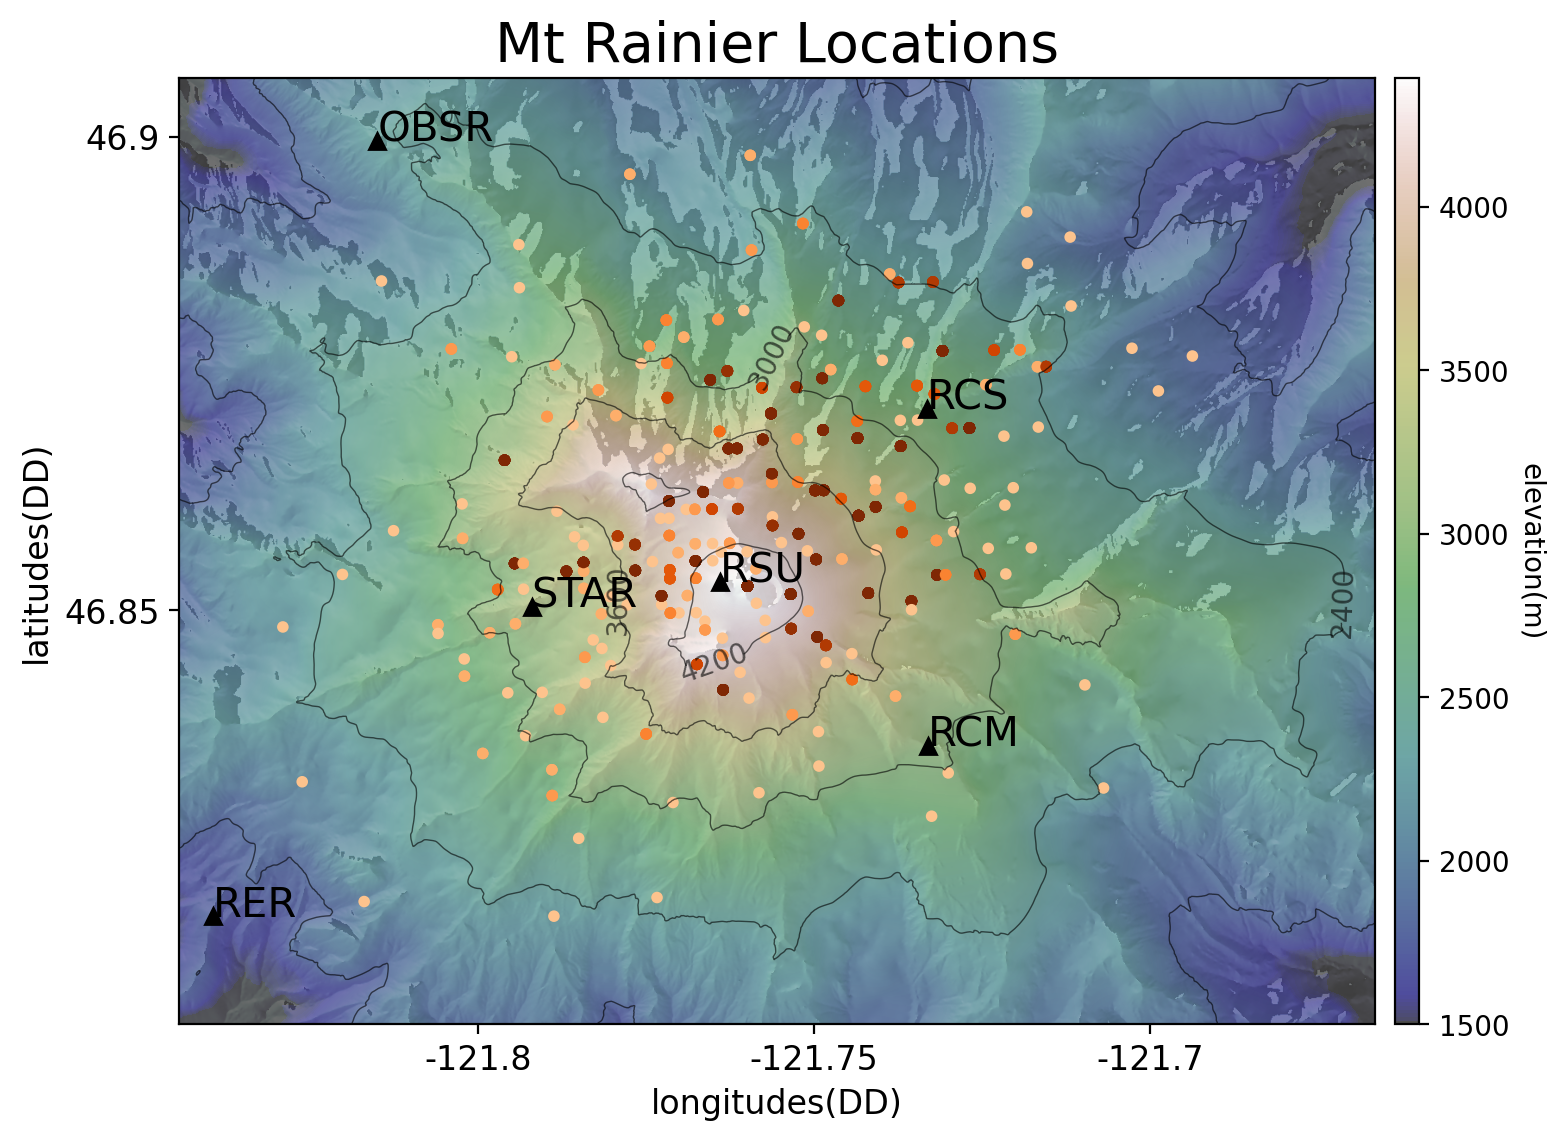

In [49]:
n = 'Mt_Rainier'
lats = []
lons = []
evt_id = []
dir_snr = []
dir_sharp = []
direc = []
sharp = []
times = []

# selects events for each specific volcano based on its location
for i in range(len(Event_Data_r)): 
    lats.append(Event_Data_r['location_latitude'][i])
    lons.append(Event_Data_r['location_longitude'][i])
    evt_id.append(Event_Data_r['event_ID'][i])
    dir_snr.append(Event_Data_r['direction_snr(degrees)'][i])
    direc.append(Event_Data_r['direction(degrees)'][i])
    dir_sharp.append(Event_Data_r['direction_sharpness(degrees)'][i])
    times.append(Event_Data_r['origin_time'][i])

# prepare data for plots
data = dem_data_dict[n]['data']
volc = rd.rdarray(data, no_data=-9999)
aspect = np.array(rd.TerrainAttribute(volc, attrib = 'aspect'))
slope = rd.TerrainAttribute(volc,attrib = 'slope_riserun')
associated_volcano = n
crs = dem_data_dict[associated_volcano]['crs']
data = dem_data_dict[associated_volcano]['data']
info = volc_lat_lon[associated_volcano]
p2 = Proj(crs,preserve_units=False)
p1 = Proj(proj='latlong',preserve_units=False)
# gives the lower left grid point in the grid search
left_x,bottom_y = transform(p1,p2,volc_grid[associated_volcano][1],volc_grid[associated_volcano][0]) # p1,p2,lon,lat
# gives the left right, bottom, top of the grid
grid_bounds = [left_x, left_x+volc_grid[associated_volcano][2], bottom_y, bottom_y+volc_grid[associated_volcano][2]]
left, right = dem_data_dict[associated_volcano]['left'],dem_data_dict[associated_volcano]['right']
bottom, top = dem_data_dict[associated_volcano]['bottom'],dem_data_dict[associated_volcano]['top']
center_x, center_y = transform(p1,p2,info[1],info[0])

# scatter plot of locations
loc_x,loc_y = [],[]
plt.rcParams.update({'font.size': 16})
fig,ax = plt.subplots(1,1,figsize=(8,11),dpi = 200)
a = ax.imshow(data,extent=[left, right, bottom, top],cmap='gist_earth', alpha = 0.7, vmin = 1500)
b = ax.imshow(aspect,extent=[left, right, bottom, top],cmap='bone', alpha = .2)
topo_contours = ax.contour(data, extent=[left, right, bottom, top],origin="upper", colors = 'k',linewidths = 0.5, alpha = 0.6)

legend_elements = [Line2D([0], [0], marker='*', color='w', label='center of volcano',
                          markerfacecolor='r', markersize=15),
                   Line2D([0], [0], marker='.', color='w', label='estimated event location',
                          markerfacecolor='k', markersize=15)]

for i, ii in enumerate(evt_id):
    loc_lon,loc_lat = transform(p1,p2,lons[i],lats[i])
    loc_x.append(loc_lon)
    loc_y.append(loc_lat)
    
num = []   
for i in Event_Data_r['location_latitude']:
    count = list(Event_Data_r['location_latitude']).count(i)
    if count < 10:
        num.append(count)
    else:
        num.append(10)

#getting lat and lon tick marks on the axis
tick_lons = lat_lon_dict[n]['tick_lons']
tick_lats = lat_lon_dict[n]['tick_lats']
ticks_x = []
ticks_y = []
for i in range(len(tick_lons)):
    tick_x,tick_y=transform(p1,p2,tick_lons[i],tick_lats[i])
    ticks_x.append(tick_x)
    ticks_y.append(tick_y)
    tick_lons[i]=str(tick_lons[i])
    tick_lats[i]=str(tick_lats[i])
divider = make_axes_locatable(ax)
cax1 = divider.append_axes('right', size='2%', pad=0.1)
ax.set_xlabel('longitudes(DD)', fontsize = 12)
ax.set_ylabel('latitudes(DD)', fontsize = 12)
ax.set_xticks(ticks_x)
ax.set_xticklabels(tick_lons, fontsize = 12)
ax.set_yticks(ticks_y)
ax.set_yticklabels(tick_lats, fontsize = 12)
cbar = plt.colorbar(a, cax=cax1)
cbar.ax.tick_params(labelsize=10)
cbar.set_label('elevation(m)\n', rotation=270, labelpad = 13, fontsize = 10)
ax.set_xlim(left+info[3],right-info[4])
ax.set_ylim(bottom+info[5],top-info[6])
#ax.set_ylim(bottom+info[5]+1000,top-info[6])
#locs = ax.scatter(loc_x,loc_y,s = 20, c=num, cmap = 'Oranges', marker=".")
ax.clabel(topo_contours, topo_contours.levels, fontsize = 10, inline = True, inline_spacing = 0.5)
#ax.scatter(center_x, center_y, s=100,marker='*',c='lightskyblue')
#plotting the stations on top of this as triangles


for i, ii in enumerate(stations):
    sta_x,sta_y = transform(p1,p2,longitudes[i],latitudes[i])
    if left+info[3]<sta_x<right-info[4] and bottom+info[5]<sta_y<top-info[6]:
        ax.plot(sta_x,sta_y, c='k', marker="^")
        ax.text(sta_x,sta_y,ii, c='k', fontsize = 15)

# creating a new segmented colormap for the locations
import matplotlib.colors as colors

def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=100):
    new_cmap = colors.LinearSegmentedColormap.from_list(
        'trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=minval, b=maxval),
        cmap(np.linspace(minval, maxval, n)))
    return new_cmap

#cmap(np.linspace(0.2, 1, 100))
arr = np.linspace(0, 50, 100).reshape((10, 10))

cmap = plt.get_cmap('Oranges')
new_cmap = truncate_colormap(cmap, 0.3, 1)
locs = ax.scatter(loc_x,loc_y,s = 40, c=num, cmap = new_cmap, marker=".")


ax.set_title(n.split('_')[0]+' '+n.split('_')[1]+' Locations', fontsize = 20)
cbar.set_label('elevation(m)\n', rotation=270, labelpad = 13, fontsize = 10)


#ax.legend(handles=legend_elements, loc = 'upper right', fontsize = 10)
plt.savefig('Analysis_Data/locs_'+n+'.png')

Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)



A Aspect attribute calculation
C Horn, B.K.P., 1981. Hill shading and the reflectance map. Proceedings of the IEEE 69, 14–47. doi:10.1109/PROC.1981.11918

t Wall-time = 0.58625



A Slope calculation (rise/run)
C Horn, B.K.P., 1981. Hill shading and the reflectance map. Proceedings of the IEEE 69, 14–47. doi:10.1109/PROC.1981.11918

t Wall-time = 0.266842


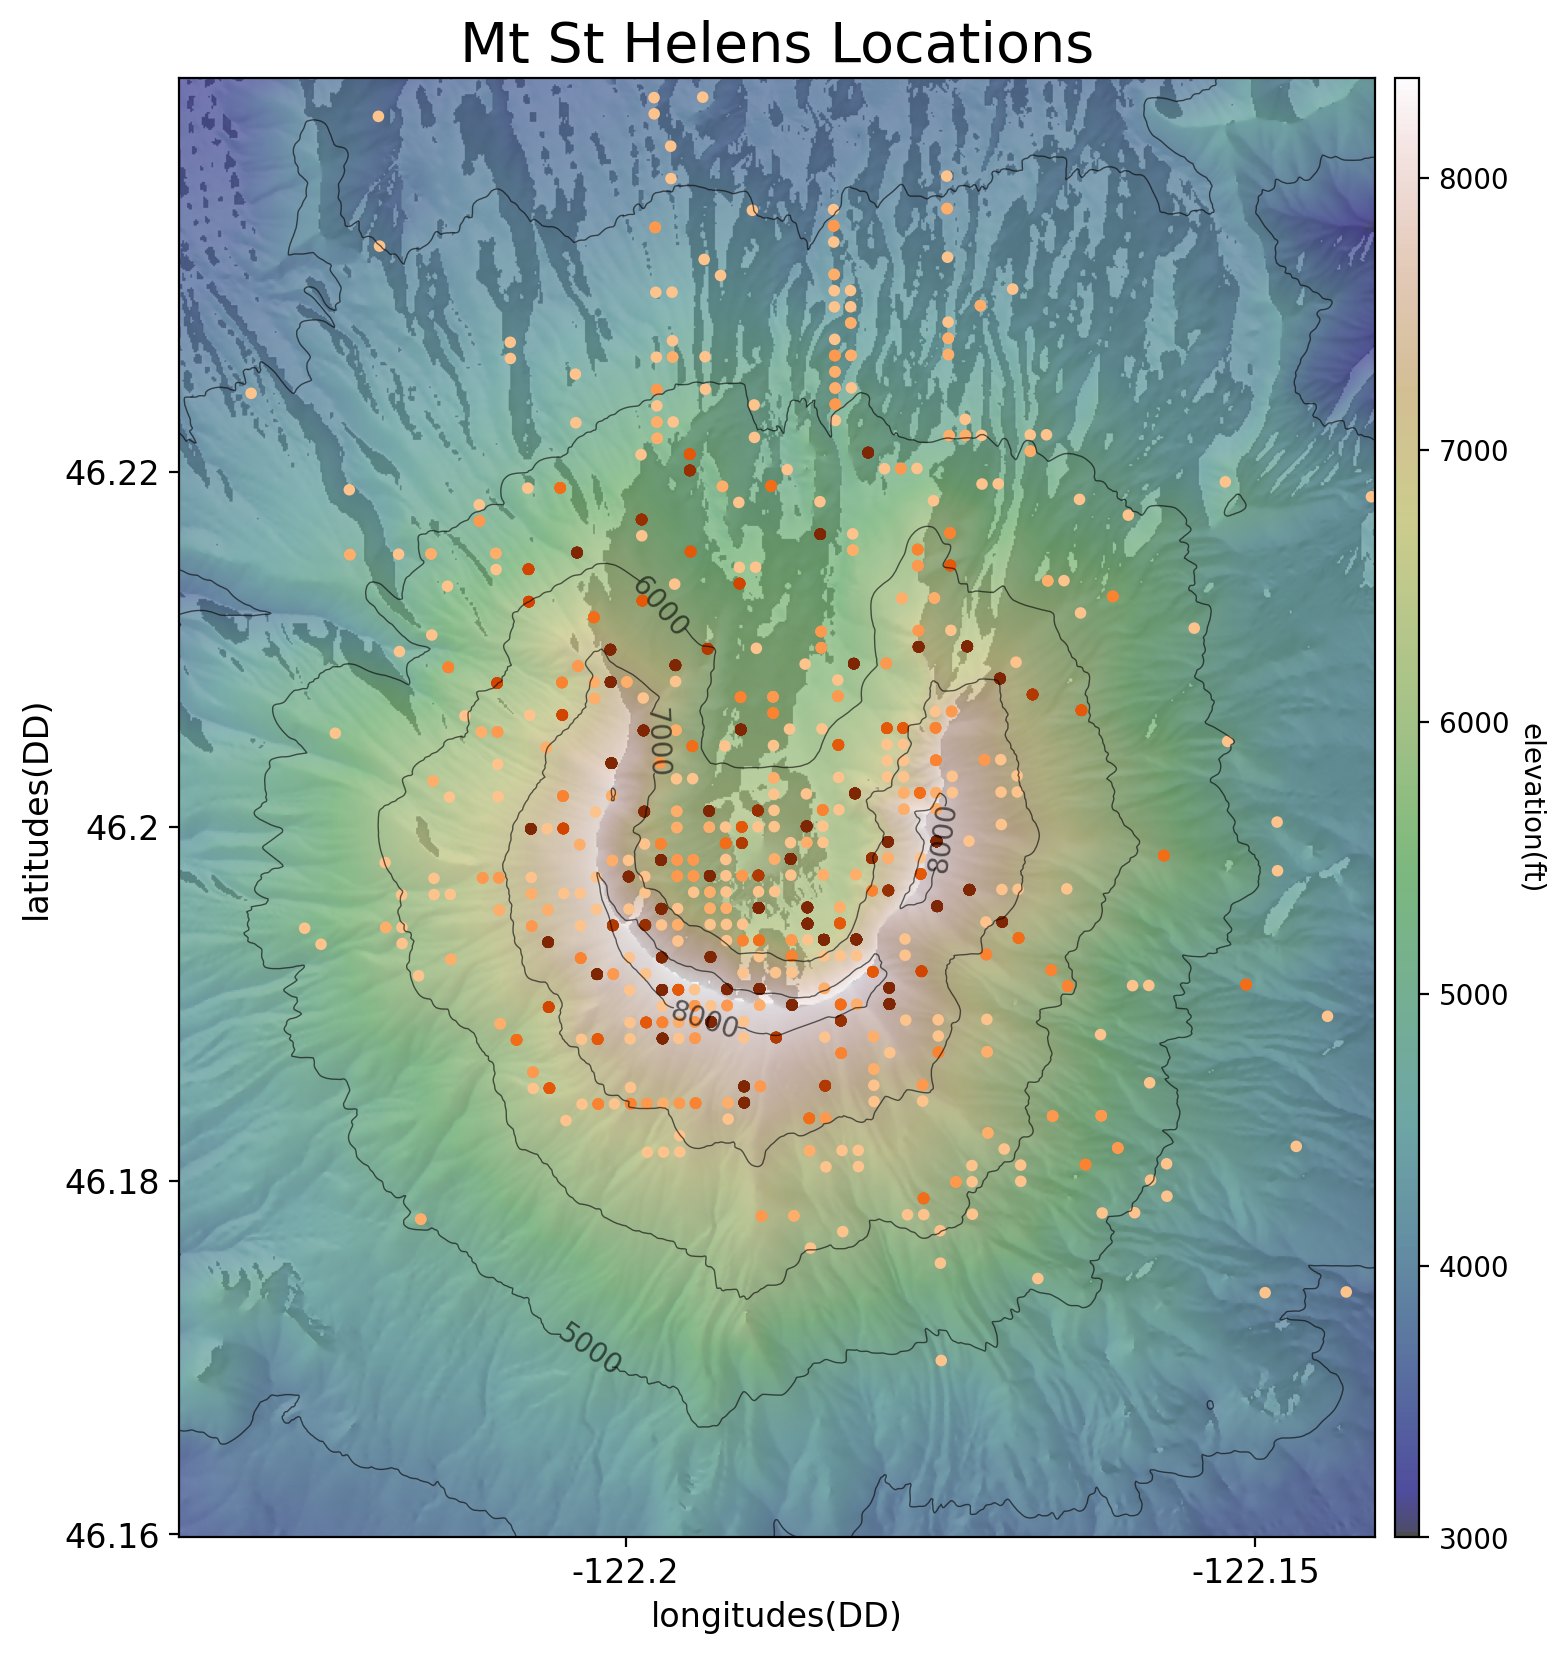

In [50]:
n = 'Mt_St_Helens'
lats = []
lons = []
evt_id = []
dir_snr = []
dir_sharp = []
direc = []
sharp = []
times = []

# selects events for each specific volcano based on its location
for i in range(len(Event_Data_st)): 
    lats.append(Event_Data_st['location_latitude'][i])
    lons.append(Event_Data_st['location_longitude'][i])
    evt_id.append(Event_Data_st['event_ID'][i])
    dir_snr.append(Event_Data_st['direction_snr(degrees)'][i])
    direc.append(Event_Data_st['direction(degrees)'][i])
    dir_sharp.append(Event_Data_st['direction_sharpness(degrees)'][i])
    times.append(Event_Data_st['origin_time'][i])

# prepare data for plots
data = dem_data_dict[n]['data']
volc = rd.rdarray(data, no_data=-9999)
aspect = np.array(rd.TerrainAttribute(volc, attrib = 'aspect'))
slope = rd.TerrainAttribute(volc,attrib = 'slope_riserun')
associated_volcano = n
crs = dem_data_dict[associated_volcano]['crs']
data = dem_data_dict[associated_volcano]['data']
info = volc_lat_lon[associated_volcano]
p2 = Proj(crs,preserve_units=False)
p1 = Proj(proj='latlong',preserve_units=False)
# gives the lower left grid point in the grid search
left_x,bottom_y = transform(p1,p2,volc_grid[associated_volcano][1],volc_grid[associated_volcano][0]) # p1,p2,lon,lat
# gives the left right, bottom, top of the grid
grid_bounds = [left_x, left_x+volc_grid[associated_volcano][2], bottom_y, bottom_y+volc_grid[associated_volcano][2]]
left, right = dem_data_dict[associated_volcano]['left'],dem_data_dict[associated_volcano]['right']
bottom, top = dem_data_dict[associated_volcano]['bottom'],dem_data_dict[associated_volcano]['top']
center_x, center_y = transform(p1,p2,info[1],info[0])

# scatter plot of locations
loc_x,loc_y = [],[]
plt.rcParams.update({'font.size': 16})
fig,ax = plt.subplots(1,1,figsize=(8,11),dpi = 200)
a = ax.imshow(data,extent=[left, right, bottom, top],cmap='gist_earth', alpha = 0.7, vmin = 3000)
b = ax.imshow(aspect,extent=[left, right, bottom, top],cmap='bone', alpha = .2)
topo_contours = ax.contour(data, extent=[left, right, bottom, top],origin="upper", colors = 'k',linewidths = 0.5, alpha = 0.6)

legend_elements = [Line2D([0], [0], marker='*', color='w', label='center of volcano',
                          markerfacecolor='r', markersize=15),
                   Line2D([0], [0], marker='.', color='w', label='estimated event location',
                          markerfacecolor='k', markersize=15)]

for i, ii in enumerate(evt_id):
    loc_lon,loc_lat = transform(p1,p2,lons[i],lats[i])
    loc_x.append(loc_lon)
    loc_y.append(loc_lat)
    
num = []   
for i in Event_Data_st['location_latitude']:
    count = list(Event_Data_st['location_latitude']).count(i)
    if count < 10:
        num.append(count)
    else:
        num.append(10)

#getting lat and lon tick marks on the axis
tick_lons = lat_lon_dict[n]['tick_lons']
tick_lats = lat_lon_dict[n]['tick_lats']
ticks_x = []
ticks_y = []
for i in range(len(tick_lons)):
    tick_x,tick_y=transform(p1,p2,tick_lons[i],tick_lats[i])
    ticks_x.append(tick_x)
    ticks_y.append(tick_y)
    tick_lons[i]=str(tick_lons[i])
    tick_lats[i]=str(tick_lats[i])
divider = make_axes_locatable(ax)
cax1 = divider.append_axes('right', size='2%', pad=0.1)
ax.set_xlabel('longitudes(DD)', fontsize = 12)
ax.set_ylabel('latitudes(DD)', fontsize = 12)
ax.set_xticks(ticks_x)
ax.set_xticklabels(tick_lons, fontsize = 12)
ax.set_yticks(ticks_y)
ax.set_yticklabels(tick_lats, fontsize = 12)
cbar = plt.colorbar(a, cax=cax1)
cbar.ax.tick_params(labelsize=10)
cbar.set_label('elevation(m)\n', rotation=270, labelpad = 13, fontsize = 10)
ax.set_xlim(left+info[3],right-info[4])
ax.set_ylim(bottom+info[5],top-info[6])
#ax.set_ylim(bottom+info[5]+1000,top-info[6])
#locs = ax.scatter(loc_x,loc_y,s = 20, c=num, cmap = 'Oranges', marker=".")
ax.clabel(topo_contours, topo_contours.levels, fontsize = 10, inline = True, inline_spacing = 0.5)
#ax.scatter(center_x, center_y, s=100,marker='*',c='lightskyblue')
#plotting the stations on top of this as triangles


for i, ii in enumerate(stations):
    sta_x,sta_y = transform(p1,p2,longitudes[i],latitudes[i])
    if left+info[3]<sta_x<right-info[4] and bottom+info[5]<sta_y<top-info[6]:
        ax.plot(sta_x,sta_y, c='k', marker="^")
        ax.text(sta_x,sta_y,ii, c='k', fontsize = 15)

# creating a new segmented colormap for the locations
import matplotlib.colors as colors

def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=100):
    new_cmap = colors.LinearSegmentedColormap.from_list(
        'trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=minval, b=maxval),
        cmap(np.linspace(minval, maxval, n)))
    return new_cmap

#cmap(np.linspace(0.2, 1, 100))
arr = np.linspace(0, 50, 100).reshape((10, 10))

cmap = plt.get_cmap('Oranges')
new_cmap = truncate_colormap(cmap, 0.3, 1)
locs = ax.scatter(loc_x,loc_y,s = 40, c=num, cmap = new_cmap, marker=".")


ax.set_title(n.split('_')[0]+' '+n.split('_')[1]+' '+n.split('_')[2]+ ' Locations', fontsize= 20)
cbar.set_label('elevation(ft)\n', rotation=270, labelpad = 13, fontsize = 10)

#ax.legend(handles=legend_elements, loc = 'upper right', fontsize = 10)
plt.savefig('Analysis_Data/locs_'+n+'.png')

Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)



A Aspect attribute calculation
C Horn, B.K.P., 1981. Hill shading and the reflectance map. Proceedings of the IEEE 69, 14–47. doi:10.1109/PROC.1981.11918

t Wall-time = 4.61123


Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)



A Slope calculation (rise/run)
C Horn, B.K.P., 1981. Hill shading and the reflectance map. Proceedings of the IEEE 69, 14–47. doi:10.1109/PROC.1981.11918

t Wall-time = 2.03682


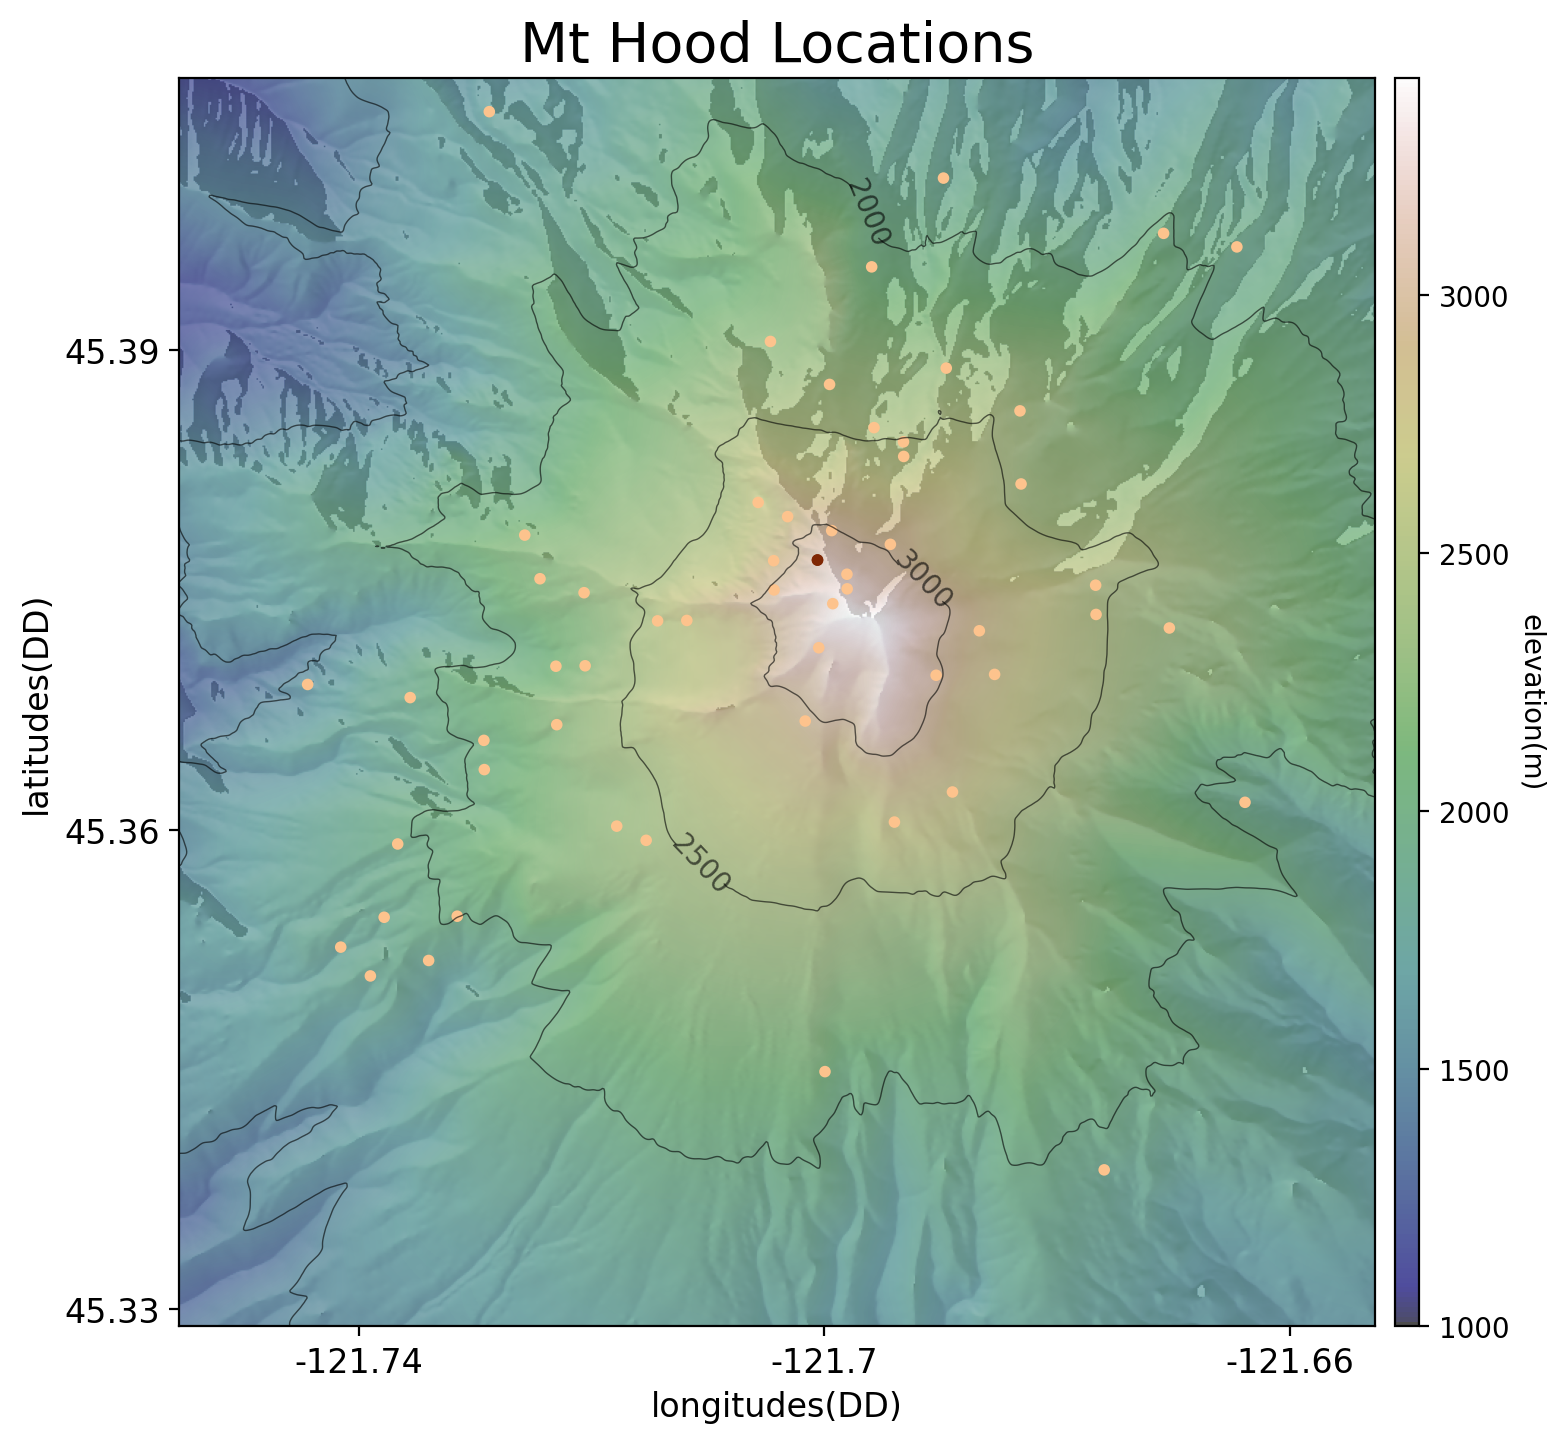

In [51]:
n = 'Mt_Hood'
lats = []
lons = []
evt_id = []
dir_snr = []
dir_sharp = []
direc = []
sharp = []
times = []

# selects events for each specific volcano based on its location
for i in range(len(Event_Data_h)): 
    lats.append(Event_Data_h['location_latitude'][i])
    lons.append(Event_Data_h['location_longitude'][i])
    evt_id.append(Event_Data_h['event_ID'][i])
    dir_snr.append(Event_Data_h['direction_snr(degrees)'][i])
    direc.append(Event_Data_h['direction(degrees)'][i])
    dir_sharp.append(Event_Data_h['direction_sharpness(degrees)'][i])
    times.append(Event_Data_h['origin_time'][i])

associated_volcano = n
# prepare data for plots
data = dem_data_dict[n]['data']
volc = rd.rdarray(data, no_data=-9999)
aspect = np.array(rd.TerrainAttribute(volc, attrib = 'aspect'))
slope = rd.TerrainAttribute(volc,attrib = 'slope_riserun')
associated_volcano = n
crs = dem_data_dict[associated_volcano]['crs']
data = dem_data_dict[associated_volcano]['data']
info = volc_lat_lon[associated_volcano]
p2 = Proj(crs,preserve_units=False)
p1 = Proj(proj='latlong',preserve_units=False)
# gives the lower left grid point in the grid search
left_x,bottom_y = transform(p1,p2,volc_grid[associated_volcano][1],volc_grid[associated_volcano][0]) # p1,p2,lon,lat
# gives the left right, bottom, top of the grid
grid_bounds = [left_x, left_x+volc_grid[associated_volcano][2], bottom_y, bottom_y+volc_grid[associated_volcano][2]]
left, right = dem_data_dict[associated_volcano]['left'],dem_data_dict[associated_volcano]['right']
bottom, top = dem_data_dict[associated_volcano]['bottom'],dem_data_dict[associated_volcano]['top']
center_x, center_y = transform(p1,p2,info[1],info[0])

# scatter plot of locations
loc_x,loc_y = [],[]
plt.rcParams.update({'font.size': 16})
fig,ax = plt.subplots(1,1,figsize=(8,11),dpi = 200)
a = ax.imshow(data,extent=[left, right, bottom, top],cmap='gist_earth', alpha = 0.7, vmin = 1000)
b = ax.imshow(aspect,extent=[left, right, bottom, top],cmap='bone', alpha = .2)
topo_contours = ax.contour(data, extent=[left, right, bottom, top],origin="upper", colors = 'k',linewidths = 0.5, alpha = 0.6)

legend_elements = [Line2D([0], [0], marker='*', color='w', label='center of volcano',
                          markerfacecolor='r', markersize=15),
                   Line2D([0], [0], marker='.', color='w', label='estimated event location',
                          markerfacecolor='k', markersize=15)]

for i, ii in enumerate(evt_id):
    loc_lon,loc_lat = transform(p1,p2,lons[i],lats[i])
    loc_x.append(loc_lon)
    loc_y.append(loc_lat)
    
num = []   
for i in Event_Data_h['location_latitude']:
    count = list(Event_Data_h['location_latitude']).count(i)
    if count < 10:
        num.append(count)
    else:
        num.append(10)

#getting lat and lon tick marks on the axis
tick_lons = lat_lon_dict[n]['tick_lons']
tick_lats = lat_lon_dict[n]['tick_lats']
ticks_x = []
ticks_y = []
for i in range(len(tick_lons)):
    tick_x,tick_y=transform(p1,p2,tick_lons[i],tick_lats[i])
    ticks_x.append(tick_x)
    ticks_y.append(tick_y)
    tick_lons[i]=str(tick_lons[i])
    tick_lats[i]=str(tick_lats[i])
divider = make_axes_locatable(ax)
cax1 = divider.append_axes('right', size='2%', pad=0.1)
ax.set_xlabel('longitudes(DD)', fontsize = 12)
ax.set_ylabel('latitudes(DD)', fontsize = 12)
ax.set_xticks(ticks_x)
ax.set_xticklabels(tick_lons, fontsize = 12)
ax.set_yticks(ticks_y)
ax.set_yticklabels(tick_lats, fontsize = 12)
cbar = plt.colorbar(a, cax=cax1)
cbar.ax.tick_params(labelsize=10)
cbar.set_label('elevation(m)\n', rotation=270, labelpad = 13, fontsize = 10)
ax.set_xlim(left+info[3],right-info[4])
ax.set_ylim(bottom+info[5],top-info[6])
#ax.set_ylim(bottom+info[5]+1000,top-info[6])
#locs = ax.scatter(loc_x,loc_y,s = 20, c=num, cmap = 'Oranges', marker=".")
ax.clabel(topo_contours, topo_contours.levels, fontsize = 10, inline = True, inline_spacing = 0.5)
#ax.scatter(center_x, center_y, s=100,marker='*',c='lightskyblue')
#plotting the stations on top of this as triangles


for i, ii in enumerate(stations):
    sta_x,sta_y = transform(p1,p2,longitudes[i],latitudes[i])
    if left+info[3]<sta_x<right-info[4] and bottom+info[5]<sta_y<top-info[6]:
        ax.plot(sta_x,sta_y, c='k', marker="^")
        ax.text(sta_x,sta_y,ii, c='k', fontsize = 15)

# creating a new segmented colormap for the locations
import matplotlib.colors as colors

def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=100):
    new_cmap = colors.LinearSegmentedColormap.from_list(
        'trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=minval, b=maxval),
        cmap(np.linspace(minval, maxval, n)))
    return new_cmap

#cmap(np.linspace(0.2, 1, 100))
arr = np.linspace(0, 50, 100).reshape((10, 10))

cmap = plt.get_cmap('Oranges')
new_cmap = truncate_colormap(cmap, 0.3, 1)
locs = ax.scatter(loc_x,loc_y,s = 40, c=num, cmap = new_cmap, marker=".")


ax.set_title(n.split('_')[0]+' '+n.split('_')[1]+' Locations', fontsize = 20)
cbar.set_label('elevation(m)\n', rotation=270, labelpad = 13, fontsize = 10)

#ax.legend(handles=legend_elements, loc = 'upper right', fontsize = 10)
plt.savefig('Analysis_Data/locs_'+n+'.png')

Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)



A Aspect attribute calculation
C Horn, B.K.P., 1981. Hill shading and the reflectance map. Proceedings of the IEEE 69, 14–47. doi:10.1109/PROC.1981.11918

t Wall-time = 1.01665

A Slope calculation (rise/run)
C Horn, B.K.P., 1981. Hill shading and the reflectance map. Proceedings of the IEEE 69, 14–47. doi:10.1109/PROC.1981.11918



t Wall-time = 0.467062


KeyboardInterrupt: 

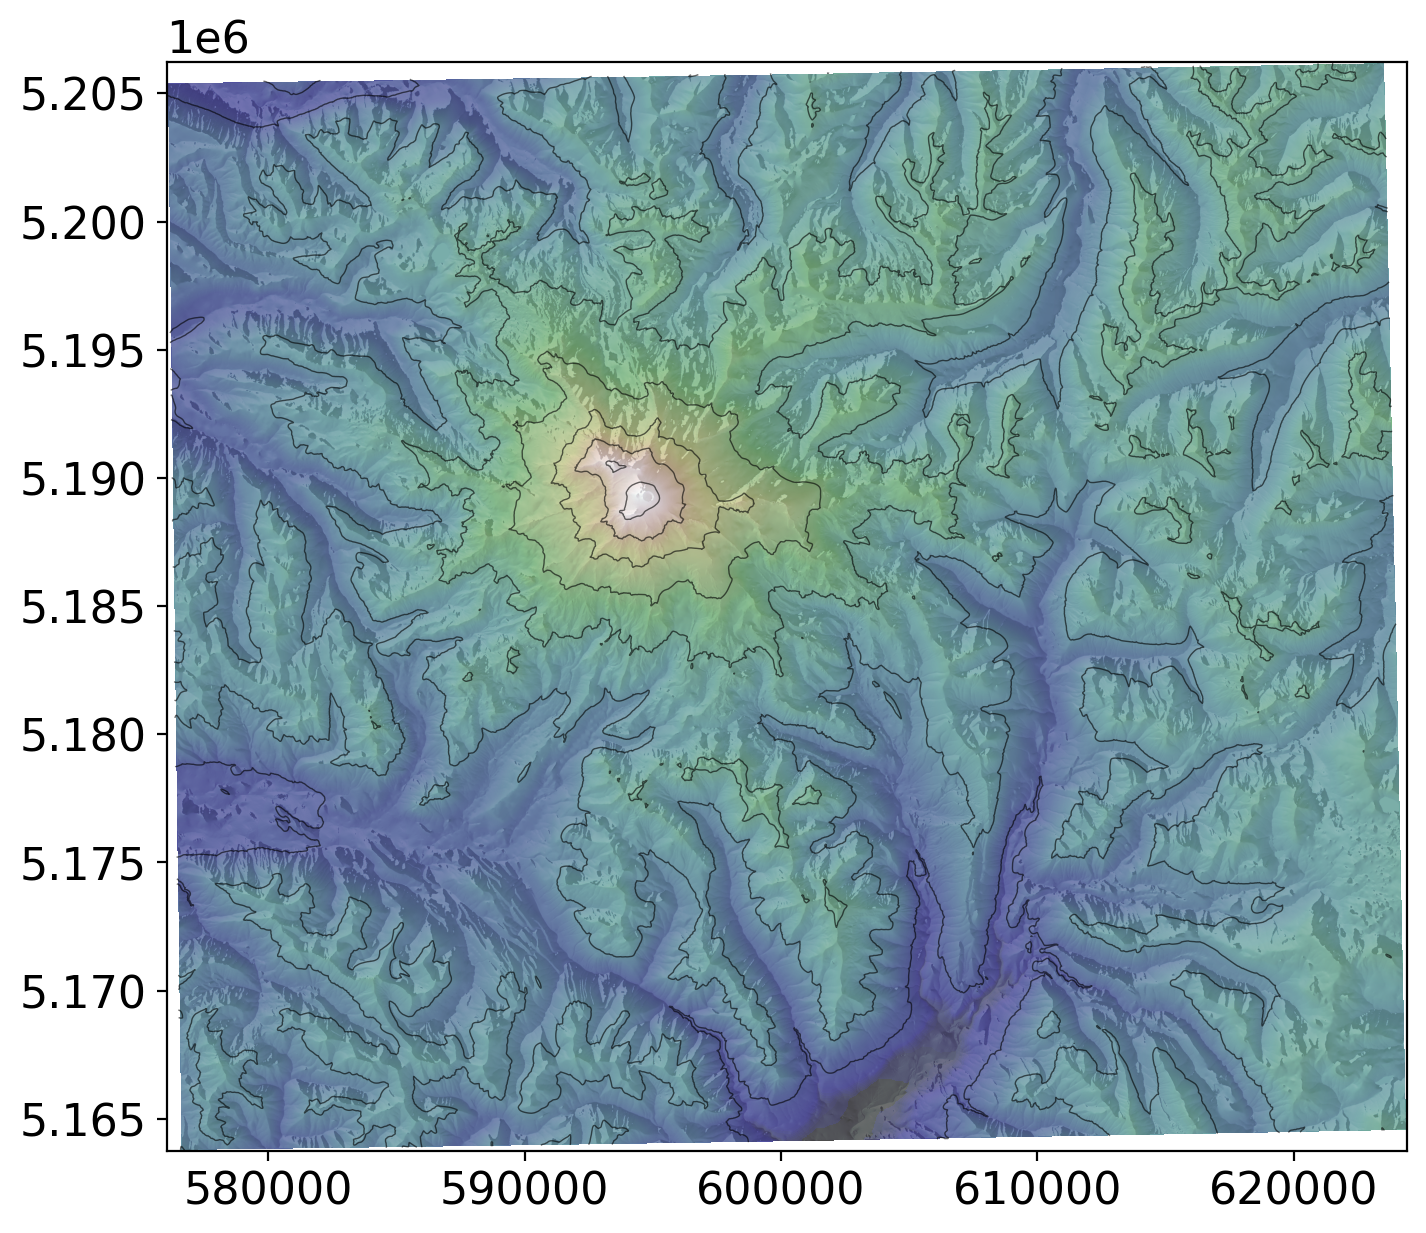

In [107]:
mtn_list = ['Mt_Rainier','Mt_St_Helens','Mt_Hood']
for n in mtn_list:
    lats = []
    lons = []
    evt_id = []
    dir_snr = []
    dir_sharp = []
    direc = []
    sharp = []
    times = []

    # selects events for each specific volcano based on its location
    for i in range(len(Event_Data)):
        if volc_loc_dict[n][0]<Event_Data['location_latitude'][i]<volc_loc_dict[n][1] and volc_loc_dict[n][2]<Event_Data['location_longitude'][i]<volc_loc_dict[n][3]:
            lats.append(Event_Data['location_latitude'][i])
            lons.append(Event_Data['location_longitude'][i])
            evt_id.append(Event_Data['event_ID'][i])
            dir_snr.append(Event_Data['direction_snr(degrees)'][i])
            direc.append(Event_Data['direction(degrees)'][i])
            dir_sharp.append(Event_Data['direction_sharpness(degrees)'][i])
            times.append(Event_Data['origin_time'][i])
    
    # prepare data for plots
    data = dem_data_dict[n]['data']
    volc = rd.rdarray(data, no_data=-9999)
    aspect = np.array(rd.TerrainAttribute(volc, attrib = 'aspect'))
    slope = rd.TerrainAttribute(volc,attrib = 'slope_riserun')
    associated_volcano = n
    crs = dem_data_dict[associated_volcano]['crs']
    data = dem_data_dict[associated_volcano]['data']
    info = volc_lat_lon[associated_volcano]
    p2 = Proj(crs,preserve_units=False)
    p1 = Proj(proj='latlong',preserve_units=False)
    # gives the lower left grid point in the grid search
    left_x,bottom_y = transform(p1,p2,volc_grid[associated_volcano][1],volc_grid[associated_volcano][0]) # p1,p2,lon,lat
    # gives the left right, bottom, top of the grid
    grid_bounds = [left_x, left_x+volc_grid[associated_volcano][2], bottom_y, bottom_y+volc_grid[associated_volcano][2]]
    left, right = dem_data_dict[associated_volcano]['left'],dem_data_dict[associated_volcano]['right']
    bottom, top = dem_data_dict[associated_volcano]['bottom'],dem_data_dict[associated_volcano]['top']
    center_x, center_y = transform(p1,p2,info[1],info[0])
    
    # scatter plot of locations
    loc_x,loc_y = [],[]
    plt.rcParams.update({'font.size': 16})
    fig,ax = plt.subplots(1,1,figsize=(8,11),dpi = 200)
    a = ax.imshow(data,extent=[left, right, bottom, top],cmap='gist_earth', alpha = 0.7)
    b = ax.imshow(aspect,extent=[left, right, bottom, top],cmap='bone', alpha = .2)
    topo_contours = ax.contour(data, extent=[left, right, bottom, top],origin="upper", colors = 'k',linewidths = 0.5, alpha = 0.6)

    legend_elements = [Line2D([0], [0], marker='*', color='w', label='center of volcano',
                              markerfacecolor='r', markersize=15),
                       Line2D([0], [0], marker='.', color='w', label='estimated event location',
                              markerfacecolor='k', markersize=15)]

    for i, ii in enumerate(evt_id):
        loc_lon,loc_lat = transform(p1,p2,lons[i],lats[i])
        loc_x.append(loc_lon)
        loc_y.append(loc_lat)

    #getting lat and lon tick marks on the axis
    tick_lons = lat_lon_dict[n]['tick_lons']
    tick_lats = lat_lon_dict[n]['tick_lats']
    ticks_x = []
    ticks_y = []
    for i in range(len(tick_lons)):
        tick_x,tick_y=transform(p1,p2,tick_lons[i],tick_lats[i])
        ticks_x.append(tick_x)
        ticks_y.append(tick_y)
        tick_lons[i]=str(tick_lons[i])
        tick_lats[i]=str(tick_lats[i])
    divider = make_axes_locatable(ax)
    cax1 = divider.append_axes('right', size='2%', pad=0.1)
    ax.set_xlabel('longitudes(DD)', fontsize = 10)
    ax.set_ylabel('latitudes(DD)', fontsize = 10)
    ax.set_xticks(ticks_x)
    ax.set_xticklabels(tick_lons, fontsize = 10)
    ax.set_yticks(ticks_y)
    ax.set_yticklabels(tick_lats, fontsize = 10)
    cbar = plt.colorbar(a, cax=cax1)
    cbar.ax.tick_params(labelsize=10)
    cbar.set_label('elevation(m)\n', rotation=270, labelpad = 13, fontsize = 10)
    ax.set_xlim(left+info[3],right-info[4])
    ax.set_ylim(bottom+info[5],top-info[6])
    #ax.set_ylim(bottom+info[5]+1000,top-info[6])
    ax.scatter(loc_x,loc_y,s = 5, c='k', marker=".")
    ax.clabel(topo_contours, topo_contours.levels, fontsize = 10, inline = True, inline_spacing = 0.5)
    ax.scatter(center_x, center_y, s=100,marker='*',c='lightskyblue')

    if n == 'Mt_Rainier' or n =='Mt_Hood':
        ax.set_title(n.split('_')[0]+' '+n.split('_')[1]+' Locations', fontsize = 20)
        cbar.set_label('elevation(m)\n', rotation=270, labelpad = 13, fontsize = 10)
    else:
        ax.set_title(n.split('_')[0]+' '+n.split('_')[1]+' '+n.split('_')[2]+ ' Locations', fontsize= 20)
        cbar.set_label('elevation(ft)\n', rotation=270, labelpad = 13, fontsize = 10)

    #ax.legend(handles=legend_elements, loc = 'upper right', fontsize = 10)
    plt.savefig('locs_'+n+'.png')

## Histograms of Velocities at each Volcano

In [ ]:
mtn_list = ['Mt_Rainier','Mt_St_Helens', 'Mt_Hood']
for n in mtn_list:
    vel = []
    times = []
    new_vel = []
    for i in range(len(Event_Data)):
        if volc_loc_dict[n][0]<Event_Data['location_latitude'][i]<volc_loc_dict[n][1] and volc_loc_dict[n][2]<Event_Data['location_longitude'][i]<volc_loc_dict[n][3]:
            vel.append(Event_Data['velocity(m/s)'][i])
            times.append(Event_Data['origin_time'][i])
    for i in vel:
        if int(i) <= 300:
            new_vel.append(i)
    # histogram of velocities
    a = np.median(new_vel)
    plt.rcParams.update({'font.size': 15})
    fig,ax = plt.subplots(figsize = [11,8], dpi = 200)
    if n == 'Mt_Rainier' or n =='Mt_Hood':
        ax.set_title(n.split('_')[0]+' '+n.split('_')[1]+' Flow Velocities')
    else:
         ax.set_title(n.split('_')[0]+' '+n.split('_')[1]+' '+n.split('_')[2]+' Flow Velocities')   
    ax.set_ylabel('number of events', fontsize = 10)
    ax.set_xlabel('velocity (m/s)', fontsize = 10)
    binwidth = 5
    num_of_events = ax.hist(new_vel,bins=range(int(min(new_vel)), int(max(new_vel)) + binwidth, binwidth), color = 'lightskyblue',edgecolor = "black")
    height = int(num_of_events[0].max()+5)
    ax.grid('True')
    ax.vlines(a,0,height-1,'firebrick','--', label = 'Median Velocity', linewidth = 3)
    ax.set_xlim([0,300])
    ax.set_ylim([0,70])
    ax.legend(fontsize = 10)
    ax.set_ylim(0,height)
    plt.xticks(fontsize = 10)
    plt.yticks(fontsize = 10)
    plt.savefig('vels'+n+'.png')


## Aspect plotted versus azimuth, and Slope plotted versus velocity

In [ ]:
#DEM data 
# r_dem_data_dict = {}
# name = 'Mt_Rainier'
# if volc_lat_lon[name][0]>46:
#     dem = rio.open('Data/DEM_data/'+str(name)+'/'+str(name)+'1.tif') #washington volcanoes
#     dem_array = dem.read(1).astype('float64')
#     dem_array[dem_array == -32767] = np.nan #gets rid of edge effects
#     crs = dem.crs

# r_dem_data_dict[name]={'data':dem_array, 'crs':crs, 'left':dem.bounds[0], 'right':dem.bounds[2], 'bottom':dem.bounds[1], 'top':dem.bounds[3]}

In [ ]:

for n in mtn_list:
    crs = dem_data_dict[n]['crs']
    data = dem_data_dict[n]['data']
    volc = rd.rdarray(data, no_data=-9999)
    slope = rd.TerrainAttribute(volc,attrib = 'slope_riserun')
    aspect = np.array(rd.TerrainAttribute(volc, attrib = 'aspect'))
    p2 = Proj(crs,preserve_units=False)
    p1 = Proj(proj='latlong',preserve_units=False)
    # gives the lower left grid point in the grid search
    left_x,bottom_y = transform(p1,p2,volc_grid[n][1],volc_grid[n][0])
    # gives the left right, bottom, top of the grid
    left, right = dem_data_dict[n]['left'],dem_data_dict[n]['right']
    bottom, top = dem_data_dict[n]['bottom'],dem_data_dict[n]['top']
    
    side = int(volc_grid[n][2]/10)
    
    # interpolating the slope and aspect matrices to 100m by 100m boxes 
    a = int((left_x-left)/10)
    b = a+side
    c = (aspect.shape[0] - int((bottom_y-bottom)/10))-side
    d = aspect.shape[0] - int((bottom_y-bottom)/10)

    x = np.arange(a,b,1)
    y = np.arange(c,d,1)

    x2 = np.arange(a,b,10) # every 100m
    y2 = np.arange(c,d,10) # every 100m

    aspect_data = np.array(aspect[c:d,a:b])

    aspect_interp_mat = RectBivariateSpline(y,x,aspect_data, s = 0)

    interp = aspect_interp_mat(x2,y2)

    slope_data = np.array(slope[c:d,a:b])

    slope_interp_mat = RectBivariateSpline(y,x,slope_data, s = 0)

    interp = slope_interp_mat(x2,y2)
    
    # Finding the aspect and slope at the given locations of each event
    aspects = []
    for i in range(0, len(Event_Data_r)):
        lon_x = Event_Data_r['location_longitude'][i]
        lat_y = Event_Data_r['location_latitude'][i]
        x, y = transform(p1,p2,lon_x, lat_y)

        asp = interp[int((x-left_x)/100),int((y-bottom_y)/100)]  
        aspects.append(asp)

    slopes = []
    for i in range(0, len(Event_Data_r)):
        lon_x = Event_Data_r['location_longitude'][i]
        lat_y = Event_Data_r['location_latitude'][i]
        x, y = transform(p1,p2,lon_x, lat_y)
    
        slo = interp[int((x-left_x)/100),int((y-bottom_y)/100)]  
        slopes.append(slo)
        
    azimuths = Event_Data_r['direction_snr(degrees)']
    linear_x = np.arange(0,360,1)
    linear_y = np.arange(0,360,1)

    velocities = Event_Data_r['velocity(m/s)']
    linear_x = np.arange(0,600,30)
    linear_y = np.arange(0,20,1)

    # plotting the results
    fig,ax = plt.subplots(1,1,figsize=(6,6),dpi = 200)
    for i in range(len(azimuths)):
        if 0<azimuths[i]<360:
            ax.scatter(aspects[i], azimuths[i], c = 'k')
    ax.plot(linear_x, linear_y)
    ax.set_title(str(name)+'aspect vs azimuth')
    ax.set_xlabel('aspect')
    ax.set_ylabel('calculated azimuth')

    fig,ax = plt.subplots(1,1,figsize=(6,6),dpi = 200)
    for i in range(len(velocities)):
        ax.scatter(slopes[i], velocities[i], c = 'k')
    ax.set_title(str(name)+'slope vs velocity')    
    ax.set_xlabel('slope')
    ax.set_ylabel('calculated_velocity')
    ax.plot(linear_y, linear_x)

 

In [33]:
a = int((left_x-left)/10)
b = a+2500
c = (aspect.shape[0] - int((bottom_y-bottom)/10))-2500
d = aspect.shape[0] - int((bottom_y-bottom)/10)

x = np.arange(a,b,1)
y = np.arange(c,d,1)

x2 = np.arange(a,b,10) # every 100m
y2 = np.arange(c,d,10) # every 100m

aspect_data = np.array(aspect[c:d,a:b])

aspect_interp_mat = RectBivariateSpline(y,x,aspect_data, s = 0)

interp = aspect_interp_mat(x2,y2)

slope_data = np.array(slope[c:d,a:b])

slope_interp_mat = RectBivariateSpline(y,x,slope_data, s = 0)

interp2 = slope_interp_mat(x2,y2)

In [34]:
aspects = []
for i in range(0, len(Event_Data_r)):
    lon_x = Event_Data_r['location_longitude'][i]
    lat_y = Event_Data_r['location_latitude'][i]
    x, y = transform(p1,p2,lon_x, lat_y)
    
    asp = interp[int((x-left_x)/100),int((y-bottom_y)/100)]  
    aspects.append(asp)
    
slopes = []
for i in range(0, len(Event_Data_r)):
    lon_x = Event_Data_r['location_longitude'][i]
    lat_y = Event_Data_r['location_latitude'][i]
    x, y = transform(p1,p2,lon_x, lat_y)
    
    slo = interp2[int((x-left_x)/100),int((y-bottom_y)/100)]  
    slopes.append(slo)

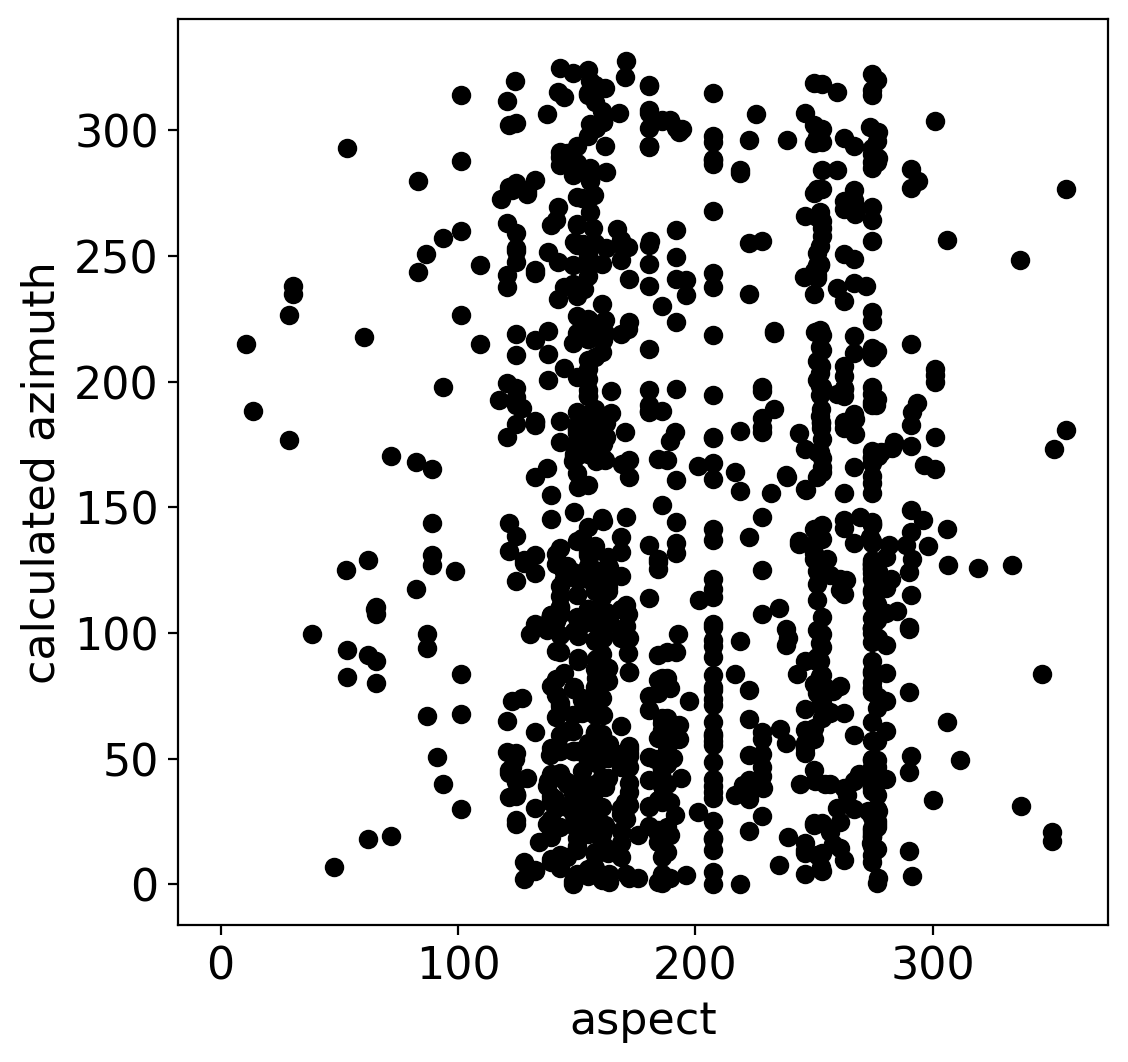

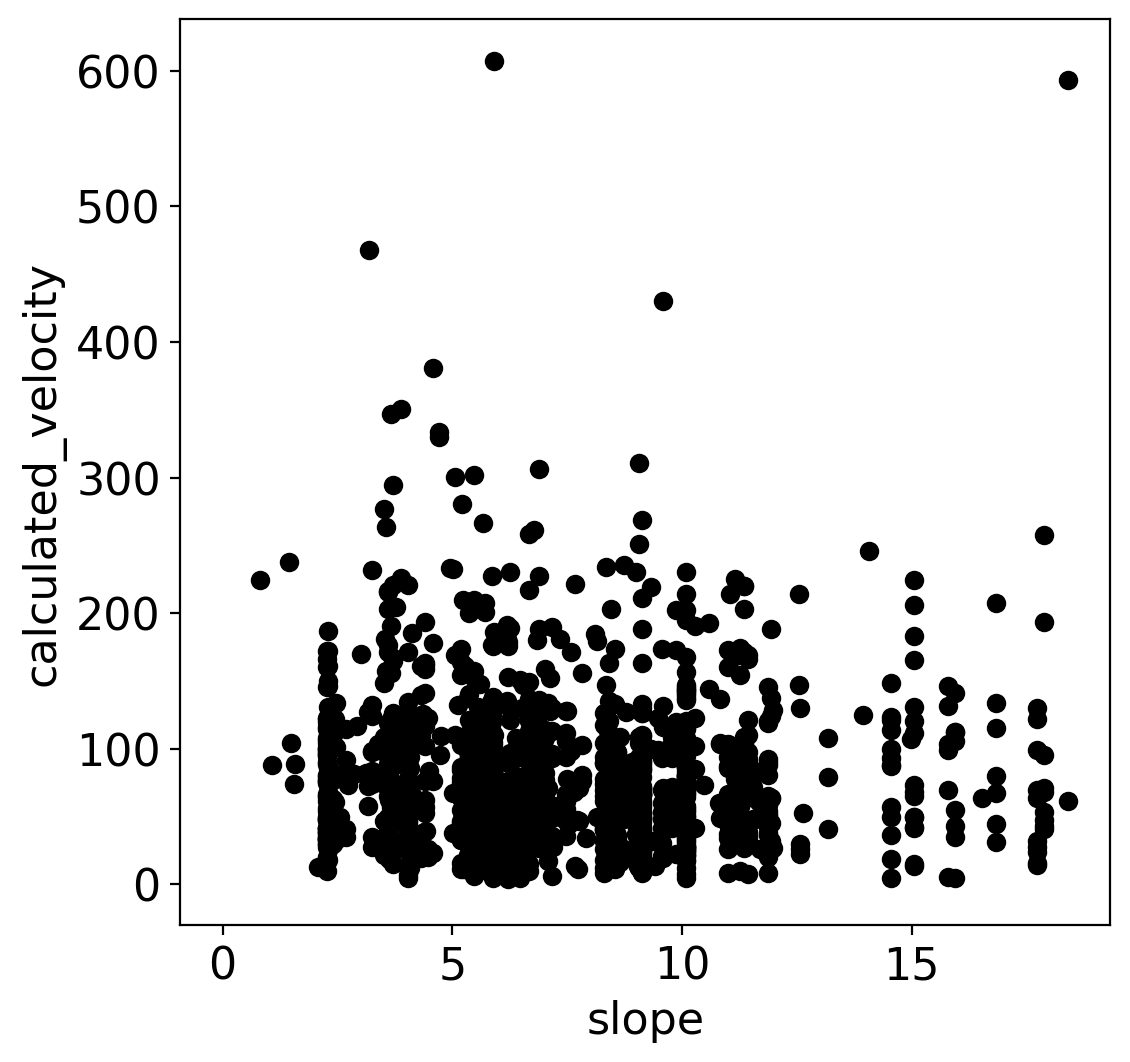

In [36]:
azimuths = Event_Data_r['direction_snr(degrees)']
linear_x = np.arange(0,360,1)
linear_y = np.arange(0,360,1)

velocities = Event_Data_r['velocity(m/s)']
linear_x = np.arange(0,20,30)
linear_y = np.arange(0,20,30)

fig,ax = plt.subplots(1,1,figsize=(6,6),dpi = 200)
for i in range(len(azimuths)):
    if 0<azimuths[i]<360:
        ax.scatter(aspects[i], azimuths[i], c = 'k')
ax.plot(linear_x, linear_y)
ax.set_xlabel('aspect')
ax.set_ylabel('calculated azimuth')

fig,ax = plt.subplots(1,1,figsize=(6,6),dpi = 200)
for i in range(len(velocities)):
    ax.scatter(slopes[i], velocities[i], c = 'k')
ax.set_xlabel('slope')
ax.set_ylabel('calculated_velocity')
ax.plot(linear_y, linear_x)

In [ ]:
# velocity vs day of year
# nicer font sizes (not too small)
# manual check
# figure with maps, waveforms, labels
    # manually look at the snr thr and waveforms and decide on a standard, loop until something looks off and check it